# Anchor Optimization for RetinaNet

**Author:** [Usha Rengaraju](https://www.linkedin.com/in/usha-rengaraju-b570b7a2/)<br>
**Date created:** 2023/06/21<br>
**Last modified:** 2023/06/21<br>
**Description:** Anchor Optimization for RetinaNet.

## Introduction
This notebook demonstrates anchor optimization techniques for RetinaNet using KerasCV. KerasCV is a computer vision library which contains object detection specific data augmentation techniques, Keras native COCO metrics, bounding box format conversion utilities, visualization tools, pretrained object detection models.

The demonstration includes the adapted version of paper implementation -[Improving RetinaNet for CT Lesion Detection with Dense Masks from Weak RECIST Labels](https://arxiv.org/abs/1906.02283) by Martin Zlocha, Qi Dou and Ben Glocker. The paper proposes optimization of anchor configurations using a differential evolution search algorithm.

## Setup

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

In [ ]:
!tar -xvf /content/VOCtrainval_06-Nov-2007.tar

In [ ]:
!pip install --quiet keras-retinanet

In [ ]:
!gsutil cp gs://cloud-ai-platform-97bb2539-a537-458c-96c8-389b8af9455a/anchor-optimization-master.zip /content/

In [ ]:
!unzip /content/anchor-optimization-master.zip

In [ ]:
%cd /content/anchor-optimization-master
!pip install -q .
!python setup.py build_ext --inplace

In [ ]:
%cd /content/anchor-optimization-master/anchor_optimization/
!python optimize_anchors_argparse.py /content/labels.csv

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv

In [ ]:
from keras_retinanet.preprocessing import *

import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm


In [ ]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = ('/content/VOCdevkit/VOC2007/JPEGImages/'+root.find('filename').text,

                     xmin,
                     ymin,
                     xmax,
                     ymax,label
                     )
            xml_list.append(value)
    column_name = ['filename', 'xmin', 'ymin', 'xmax', 'ymax','class']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = '/content/VOCdevkit/VOC2007/Annotations'
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('labels.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


keras_cv.models API includes fully pretrained object detection models, such as keras_cv.models.RetinaNet. The code below constructs a RetinaNet pretrained on the pascalvoc dataset.The bounding_box_format argument describes the value format for the "boxes" field of the label dictionary .



In [ ]:
pretrained_model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

RetinaNet with ResNet50 backbone requires resizing the image to a size which is divisible by 64 . keras_cv.layers.Resizing layer from KerasCV is used for resizing the image size .


In [ ]:
filepath = tf.keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
image_batch = inference_resizing([image])


The class mapping parameter from keras_cv.visualization.plot_bounding_box_gallery() highlights the class each box is assigned to .model.predict() API is used for predicting the bounding boxes .



In [ ]:
class_ids = ["Aeroplane","Bicycle","Bird","Boat","Bottle","Bus","Car","Cat","Chair","Cow","Dining Table","Dog","Horse","Motorbike","Person","Potted Plant","Sheep","Sofa","Train","Tvmonitor","Total",]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

BATCH_SIZE=4
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

## Load the dataset

In [ ]:

def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xyxy"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xyxy")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteK10P66/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteK10P66/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteK10P66/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

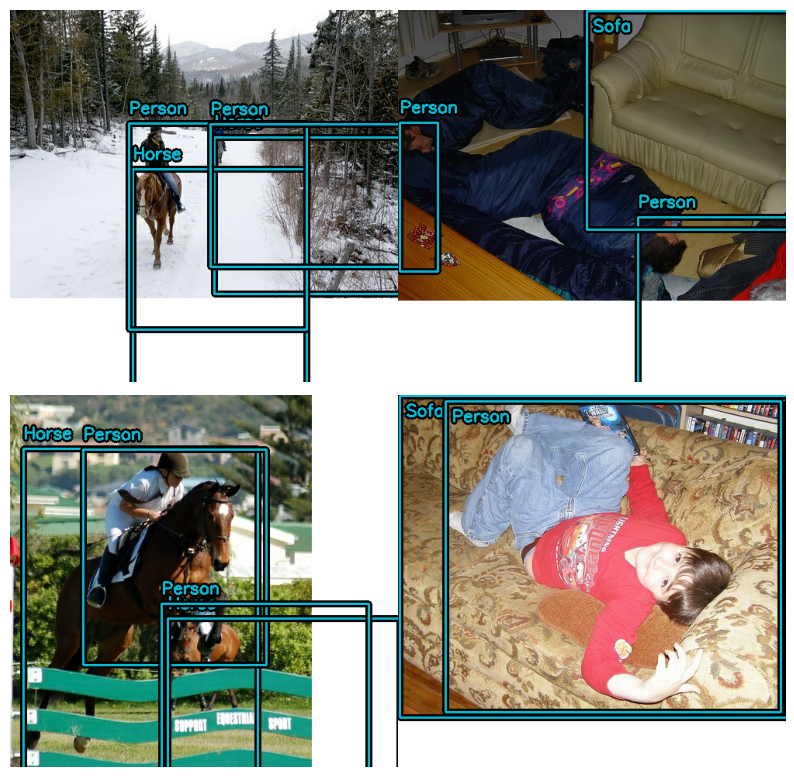

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

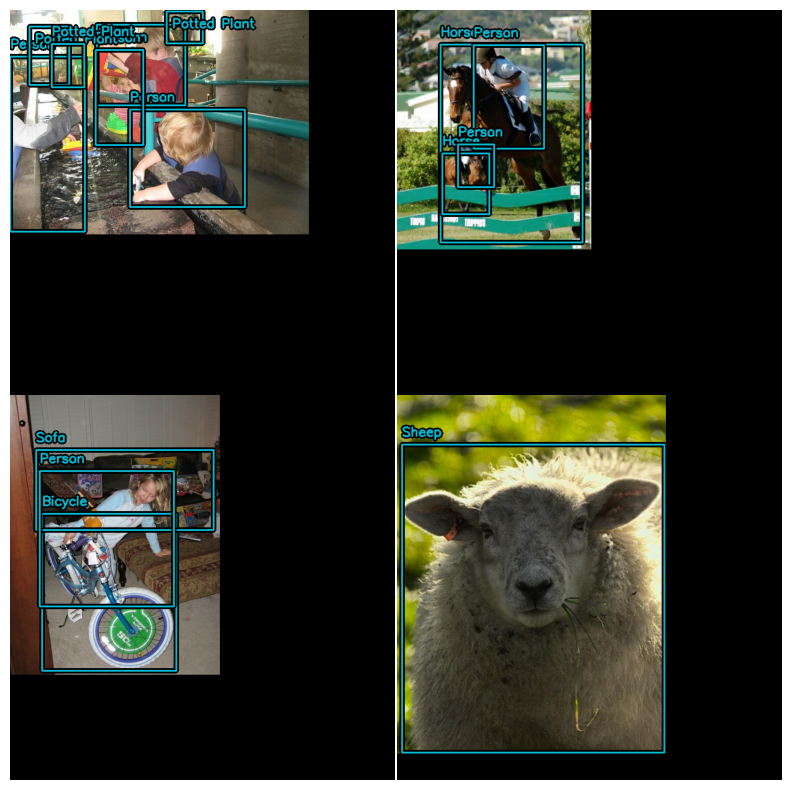

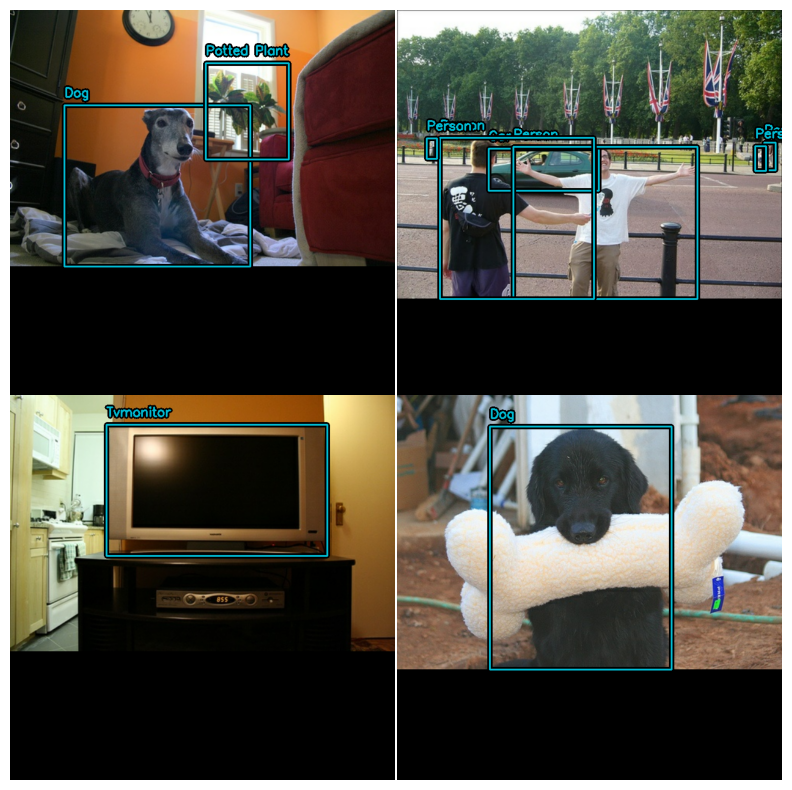

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xyxy", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

visualize_dataset(
    eval_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

## Without Optimization


In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
)

base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

94657128/94657128 [==============================] - 0s 0us/step


In [ ]:
model.fit(
    train_ds,
    validation_data=eval_ds,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=15,
    callbacks=[EvaluateCOCOMetricsCallback(eval_ds.take(20))],
)

## With Optimization

In [ ]:
# State: 0.20689
# Ratios: [0.434, 1.0, 2.302]
# Scales: [0.95, 1.217, 1.545]

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    anchor_generator = keras_cv.layers.AnchorGenerator(bounding_box_format='xyxy',scales =[0.95, 1.217, 1.545],aspect_ratios=[0.434, 1.0, 2.302] ,sizes = [32.0, 64.0, 128.0, 256.0, 512.0],
    strides = [2**i for i in range(3, 8)]),
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
)

base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

94657128/94657128 [==============================] - 1s 0us/step


In [ ]:
model.fit(
    train_ds,
    validation_data=eval_ds,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=15,
    callbacks=[EvaluateCOCOMetricsCallback(eval_ds.take(20))],
)

Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 1.2787 - box_loss: 0.5393 - classification_loss: 0.7394 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:07<00:00,  2.61it/s]

625/625 [==============================] - 574s 866ms/step - loss: 1.2787 - box_loss: 0.5393 - classification_loss: 0.7394 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 1.0574 - val_box_loss: 0.4485 - val_classification_loss: 0.6089 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.0398 - MaP@[IoU=50]: 0.1071 - MaP@[IoU=75]: 0.0093 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0337 - MaP@[area=large]: 0.0414 - Recall@[max_detections=1]: 0.0408 - Recall@[max_detections=10]: 0.0466 - Recall@[max_detections=100]: 0.0466 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0333 - Recall@[area=large]: 0.0444


Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 0.9409 - box_loss: 0.3894 - classification_loss: 0.5514 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:05<00:00,  3.73it/s]

625/625 [==============================] - 538s 861ms/step - loss: 0.9409 - box_loss: 0.3894 - classification_loss: 0.5514 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.9608 - val_box_loss: 0.3910 - val_classification_loss: 0.5698 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.0710 - MaP@[IoU=50]: 0.1564 - MaP@[IoU=75]: 0.0591 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0939 - MaP@[area=large]: 0.0941 - Recall@[max_detections=1]: 0.0571 - Recall@[max_detections=10]: 0.0882 - Recall@[max_detections=100]: 0.0882 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1197 - Recall@[area=large]: 0.1100


Epoch 3/15
625/625 [==============================] - ETA: 0s - loss: 0.8172 - box_loss: 0.3442 - classification_loss: 0.4730 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

625/625 [==============================] - 595s 952ms/step - loss: 0.8172 - box_loss: 0.3442 - classification_loss: 0.4730 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.8262 - val_box_loss: 0.3427 - val_classification_loss: 0.4835 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.0774 - MaP@[IoU=50]: 0.1395 - MaP@[IoU=75]: 0.0856 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0996 - MaP@[area=large]: 0.0945 - Recall@[max_detections=1]: 0.1117 - Recall@[max_detections=10]: 0.1230 - Recall@[max_detections=100]: 0.1230 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1043 - Recall@[area=large]: 0.1454


Epoch 4/15
625/625 [==============================] - ETA: 0s - loss: 0.7188 - box_loss: 0.3122 - classification_loss: 0.4066 - percent_boxes_matched_with_anchor: 0.9020

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

625/625 [==============================] - 542s 868ms/step - loss: 0.7188 - box_loss: 0.3122 - classification_loss: 0.4066 - percent_boxes_matched_with_anchor: 0.9020 - val_loss: 0.7408 - val_box_loss: 0.3256 - val_classification_loss: 0.4153 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.2223 - MaP@[IoU=50]: 0.3815 - MaP@[IoU=75]: 0.2365 - MaP@[area=small]: 0.0208 - MaP@[area=medium]: 0.2329 - MaP@[area=large]: 0.2161 - Recall@[max_detections=1]: 0.2166 - Recall@[max_detections=10]: 0.2558 - Recall@[max_detections=100]: 0.2558 - Recall@[area=small]: 0.0200 - Recall@[area=medium]: 0.2420 - Recall@[area=large]: 0.2463


Epoch 5/15
625/625 [==============================] - ETA: 0s - loss: 0.6762 - box_loss: 0.2920 - classification_loss: 0.3843 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

625/625 [==============================] - 542s 868ms/step - loss: 0.6762 - box_loss: 0.2920 - classification_loss: 0.3843 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.7286 - val_box_loss: 0.3068 - val_classification_loss: 0.4218 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.1256 - MaP@[IoU=50]: 0.2552 - MaP@[IoU=75]: 0.0847 - MaP@[area=small]: 0.0260 - MaP@[area=medium]: 0.1368 - MaP@[area=large]: 0.1645 - Recall@[max_detections=1]: 0.1226 - Recall@[max_detections=10]: 0.1354 - Recall@[max_detections=100]: 0.1354 - Recall@[area=small]: 0.0250 - Recall@[area=medium]: 0.1450 - Recall@[area=large]: 0.1715


Epoch 6/15
625/625 [==============================] - ETA: 0s - loss: 0.6243 - box_loss: 0.2757 - classification_loss: 0.3487 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


625/625 [==============================] - 543s 868ms/step - loss: 0.6243 - box_loss: 0.2757 - classification_loss: 0.3487 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.7138 - val_box_loss: 0.3098 - val_classification_loss: 0.4040 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.2272 - MaP@[IoU=50]: 0.4177 - MaP@[IoU=75]: 0.2390 - MaP@[area=small]: 0.0168 - MaP@[area=medium]: 0.1744 - MaP@[area=large]: 0.2453 - Recall@[max_detections=1]: 0.2191 - Recall@[max_detections=10]: 0.2562 - Recall@[max_detections=100]: 0.2562 - Recall@[area=small]: 0.0167 - Recall@[area=medium]: 0.1797 - Recall@[area=large]: 0.2732
Epoch 7/15
625/625 [==============================] - ETA: 0s - loss: 0.5791 - box_loss: 0.2590 - classification_loss: 0.3201 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

625/625 [==============================] - 594s 950ms/step - loss: 0.5791 - box_loss: 0.2590 - classification_loss: 0.3201 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6803 - val_box_loss: 0.3057 - val_classification_loss: 0.3746 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.2409 - MaP@[IoU=50]: 0.4115 - MaP@[IoU=75]: 0.2226 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1741 - MaP@[area=large]: 0.2660 - Recall@[max_detections=1]: 0.2293 - Recall@[max_detections=10]: 0.2655 - Recall@[max_detections=100]: 0.2655 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1833 - Recall@[area=large]: 0.2891


Epoch 8/15
625/625 [==============================] - ETA: 0s - loss: 0.5355 - box_loss: 0.2455 - classification_loss: 0.2900 - percent_boxes_matched_with_anchor: 0.9022

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

625/625 [==============================] - 543s 869ms/step - loss: 0.5355 - box_loss: 0.2455 - classification_loss: 0.2900 - percent_boxes_matched_with_anchor: 0.9022 - val_loss: 0.6503 - val_box_loss: 0.2886 - val_classification_loss: 0.3617 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.2732 - MaP@[IoU=50]: 0.4868 - MaP@[IoU=75]: 0.2948 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2118 - MaP@[area=large]: 0.2886 - Recall@[max_detections=1]: 0.2711 - Recall@[max_detections=10]: 0.2974 - Recall@[max_detections=100]: 0.2974 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2594 - Recall@[area=large]: 0.3064


Epoch 9/15
625/625 [==============================] - ETA: 0s - loss: 0.5214 - box_loss: 0.2360 - classification_loss: 0.2853 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:05<00:00,  3.75it/s]

625/625 [==============================] - 590s 943ms/step - loss: 0.5214 - box_loss: 0.2360 - classification_loss: 0.2853 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6470 - val_box_loss: 0.2944 - val_classification_loss: 0.3526 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.2647 - MaP@[IoU=50]: 0.4734 - MaP@[IoU=75]: 0.2967 - MaP@[area=small]: 0.0208 - MaP@[area=medium]: 0.1590 - MaP@[area=large]: 0.2763 - Recall@[max_detections=1]: 0.2778 - Recall@[max_detections=10]: 0.2945 - Recall@[max_detections=100]: 0.2945 - Recall@[area=small]: 0.0200 - Recall@[area=medium]: 0.1750 - Recall@[area=large]: 0.3028


Epoch 10/15
625/625 [==============================] - ETA: 0s - loss: 0.4936 - box_loss: 0.2256 - classification_loss: 0.2680 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


625/625 [==============================] - 540s 864ms/step - loss: 0.4936 - box_loss: 0.2256 - classification_loss: 0.2680 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6442 - val_box_loss: 0.2867 - val_classification_loss: 0.3574 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.3165 - MaP@[IoU=50]: 0.5268 - MaP@[IoU=75]: 0.3503 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1794 - MaP@[area=large]: 0.3283 - Recall@[max_detections=1]: 0.3168 - Recall@[max_detections=10]: 0.3449 - Recall@[max_detections=100]: 0.3449 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1838 - Recall@[area=large]: 0.3571
Epoch 11/15
625/625 [==============================] - ETA: 0s - loss: 0.4696 - box_loss: 0.2149 - classification_loss: 0.2546 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


625/625 [==============================] - 590s 943ms/step - loss: 0.4696 - box_loss: 0.2149 - classification_loss: 0.2546 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6414 - val_box_loss: 0.2824 - val_classification_loss: 0.3590 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.3104 - MaP@[IoU=50]: 0.5114 - MaP@[IoU=75]: 0.3491 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2781 - MaP@[area=large]: 0.3289 - Recall@[max_detections=1]: 0.3074 - Recall@[max_detections=10]: 0.3378 - Recall@[max_detections=100]: 0.3378 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2949 - Recall@[area=large]: 0.3553
Epoch 12/15
625/625 [==============================] - ETA: 0s - loss: 0.4415 - box_loss: 0.2063 - classification_loss: 0.2351 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

625/625 [==============================] - 595s 952ms/step - loss: 0.4415 - box_loss: 0.2063 - classification_loss: 0.2351 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6165 - val_box_loss: 0.2757 - val_classification_loss: 0.3408 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.3038 - MaP@[IoU=50]: 0.4831 - MaP@[IoU=75]: 0.3394 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2877 - MaP@[area=large]: 0.3163 - Recall@[max_detections=1]: 0.2826 - Recall@[max_detections=10]: 0.3318 - Recall@[max_detections=100]: 0.3318 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.3440 - Recall@[area=large]: 0.3421


Epoch 13/15
625/625 [==============================] - ETA: 0s - loss: 0.4255 - box_loss: 0.2000 - classification_loss: 0.2255 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


625/625 [==============================] - 543s 869ms/step - loss: 0.4255 - box_loss: 0.2000 - classification_loss: 0.2255 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6206 - val_box_loss: 0.2780 - val_classification_loss: 0.3426 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.3308 - MaP@[IoU=50]: 0.5305 - MaP@[IoU=75]: 0.3440 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1941 - MaP@[area=large]: 0.3750 - Recall@[max_detections=1]: 0.3234 - Recall@[max_detections=10]: 0.3574 - Recall@[max_detections=100]: 0.3574 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2367 - Recall@[area=large]: 0.3878
Epoch 14/15
625/625 [==============================] - ETA: 0s - loss: 0.4080 - box_loss: 0.1888 - classification_loss: 0.2193 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


625/625 [==============================] - 543s 869ms/step - loss: 0.4080 - box_loss: 0.1888 - classification_loss: 0.2193 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6157 - val_box_loss: 0.2750 - val_classification_loss: 0.3408 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.3027 - MaP@[IoU=50]: 0.5551 - MaP@[IoU=75]: 0.3013 - MaP@[area=small]: 0.0845 - MaP@[area=medium]: 0.1573 - MaP@[area=large]: 0.3268 - Recall@[max_detections=1]: 0.2840 - Recall@[max_detections=10]: 0.3257 - Recall@[max_detections=100]: 0.3257 - Recall@[area=small]: 0.0857 - Recall@[area=medium]: 0.1642 - Recall@[area=large]: 0.3492
Epoch 15/15
625/625 [==============================] - ETA: 0s - loss: 0.3825 - box_loss: 0.1823 - classification_loss: 0.2002 - percent_boxes_matched_with_anchor: 0.9021

100%|██████████| 20/20 [00:10<00:00,  1.91it/s]

625/625 [==============================] - 544s 870ms/step - loss: 0.3825 - box_loss: 0.1823 - classification_loss: 0.2002 - percent_boxes_matched_with_anchor: 0.9021 - val_loss: 0.6007 - val_box_loss: 0.2710 - val_classification_loss: 0.3297 - val_percent_boxes_matched_with_anchor: 0.9055 - MaP: 0.3536 - MaP@[IoU=50]: 0.5653 - MaP@[IoU=75]: 0.4416 - MaP@[area=small]: 0.0208 - MaP@[area=medium]: 0.1627 - MaP@[area=large]: 0.3859 - Recall@[max_detections=1]: 0.3364 - Recall@[max_detections=10]: 0.3830 - Recall@[max_detections=100]: 0.3830 - Recall@[area=small]: 0.0200 - Recall@[area=medium]: 0.2110 - Recall@[area=large]: 0.4121


## Visualize the predictions

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

1/1 [==============================] - 3s 3s/step


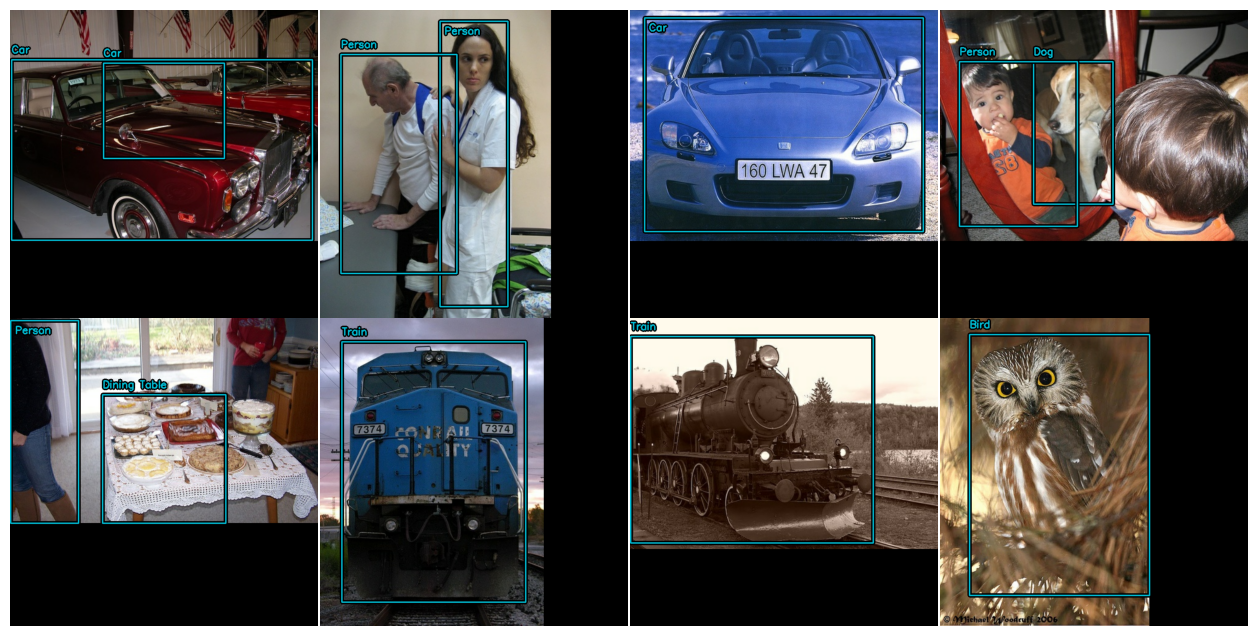

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xyxy")

**References:**

- [KerasCV Object Detection Guide](https://keras.io/guides/keras_cv/object_detection_keras_cv/)
- [Improving RetinaNet for CT Lesion Detection with Dense Masks from Weak RECIST Labels
](https://arxiv.org/abs/1906.02283)
- [Anchor Optimization](https://github.com/martinzlocha/anchor-optimization)
